In [1]:
import torch
import gym
import numpy
import torch.nn as nn
import random
import math
import time
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process, Pipe
from collections import OrderedDict
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from torch.distributions import Normal, Categorical
import os
%matplotlib inline

# Parser

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class Parser():
    '''
    Hyper-Parameters
    '''
    def __init__(self,):
        self.lr = 7e-4
        self.eps = 1e-5
        self.alpha = 0.99
        self.gamma = 0.99
        self.tau = 0.95
        self.entropy_coef = 0.01
        self.value_loss_coef = 0.5
        self.seed = 1
        self.num_processes = 16
        self.num_steps = 5
        self.num_frames = int(10e6)
        self.env_name = "Pendulum-v0" # PongNoFrameskip-v4
        self.model_path = './ACKTR/'
args = Parser()

In [3]:
def plot(frame_idx, rewards):
    '''
    For plotting the rewards.
    '''
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

def test_env(vis=False):
    '''
    Testing the model(actor_critic.base) during training.
    '''
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            _,mu = actor_critic.base(state)
            dist = Normal(mu, 1)
            next_state, reward, done, _ = env.step(dist.sample().cpu().numpy()[0])
            state = next_state
            if vis: env.render()
            total_reward += reward
    return total_reward

# SubprocVecEnv

In [4]:
'''
For creating multiple envs
'''

def worker(remote, parent_remote, env_fn_wrapper):
    parent_remote.close() 
    env = env_fn_wrapper()
    while True: # Trying to read the data all the day? A:Yes
        cmd, data = remote.recv()  # this remote is worker_remote
        if cmd == 'step':
            ob, reward, done, info = env.step(data)
            if done:
                ob = env.reset()
            remote.send((ob, reward, done, info))
        elif cmd == 'reset':
            ob = env.reset()
            remote.send(ob)
        elif cmd == 'reset_task':
            ob = env.reset_task()
            remote.send(ob)
        elif cmd == 'close':
            remote.close()
            break
        elif cmd == 'get_spaces':
            remote.send((env.observation_space, env.action_space))
        elif cmd == 'Message':
            print('Receive Message')
        else:
            raise NotImplementedError
        
class SubprocVecEnv(object):
    
    def __init__(self, env_fns, spaces=None):
        """
        envs: list of gym environments to run in subprocesses
        """
        self.waiting = False
        self.closed = False
        nenvs = len(env_fns)
        self.nenvs = nenvs
        self.remotes, self.work_remotes = zip(*[Pipe() for _ in range(nenvs)])
        self.ps = [Process(target=worker, args=(work_remote, remote, env_fn))
            for (work_remote, remote, env_fn) in zip(self.work_remotes, self.remotes, env_fns)]
        for p in self.ps:
            p.daemon = True # if the main process crashes, we should not cause things to hang
            p.start()
        for remote in self.work_remotes: 
            remote.close() # Can be shut down after the start, and close remotes in the def(function doesn't affect the self.remots in this class)
        self.remotes[0].send(('get_spaces', None))
        self.observation_space, self.action_space = self.remotes[0].recv()
        
        
    def step_async(self, actions):
        for remote, action in zip(self.remotes, actions):
            remote.send(('step', action)) # Send the message to worker remote
        self.waiting = True

    def step_wait(self):
        results = [remote.recv() for remote in self.remotes]
        self.waiting = False
        obs, rews, dones, infos = zip(*results)
        return np.stack(obs), np.stack(rews), np.stack(dones), infos

    def reset(self):
        for remote in self.remotes:
            remote.send(('reset', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def reset_task(self):
        for remote in self.remotes:
            remote.send(('reset_task', None))
        return np.stack([remote.recv() for remote in self.remotes])

    def close(self):
        if self.closed:
            return
        if self.waiting:
            for remote in self.remotes:            
                remote.recv()
        for remote in self.remotes:
            remote.send(('close', None))
        for p in self.ps:
            p.join()
            self.closed = True
            
    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()
            
    def __len__(self):
        return self.nenvs


# Rollout

In [5]:
'''
For storing the collected "Observation, rewards, values, returns, actions, action_log_probs, masks"
'''

class RolloutStorage(object):

    def __init__(self, num_steps, num_processes, obs_shape, action_space):
        self.observations = torch.zeros(args.num_steps + 1, args.num_processes, *obs_shape).to(device) #(6,16,3)
        self.rewards = torch.zeros(args.num_steps, args.num_processes, 1).to(device) # (5,16,1)
        self.value_preds = torch.zeros(args.num_steps + 1, args.num_processes, 1).to(device) #(6,16,1)
        self.returns = torch.zeros(args.num_steps + 1, args.num_processes, 1).to(device) #(6,16,1)
        self.action_log_probs = torch.zeros(args.num_steps, args.num_processes, 1).to(device) #(6,16,1)
        
        if action_space.__class__.__name__ == 'Discrete':
            action_shape = 1
        else:
            action_shape = action_space.shape[0]
        self.actions = torch.zeros(args.num_steps, args.num_processes, action_shape).to(device) #(5,16,1)
        if action_space.__class__.__name__ == 'Discrete':
            self.actions = self.actions.long().to(device)
            
        self.masks = torch.ones(args.num_steps + 1, args.num_processes, 1).to(device) #(6,16,1)

        self.num_steps = args.num_steps
        self.step = 0

    def insert(self, current_obs, action, action_log_prob, value_pred, reward, mask): # insert a new step
        
        self.observations[self.step + 1].copy_(current_obs) # insert the output to the self.
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps # restrict the self.stpe in the self.num_steps

    def after_update(self): # move the last one to the first and keep doing the next iter
        self.observations[0].copy_(self.observations[-1]) # +1 in insert, these info will be used for the next iter
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma, tau):
        '''
        Compute the returns by GAE, and it shouldn't require the gradient.
        '''
        self.value_preds[-1] = next_value
        gae = 0
        for step in reversed(range(self.rewards.size(0))):
            delta = self.rewards[step] + gamma * self.value_preds[step + 1] * self.masks[step + 1] - self.value_preds[step]
            gae = delta + gamma * tau * self.masks[step + 1] * gae
            self.returns[step] = gae + self.value_preds[step]


# Model

In [6]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)


class Policy(nn.Module):
    def __init__(self, obs_shape, action_space, std=1):
        super(Policy, self).__init__()
        
        self.base = MLPBase(obs_shape[0]) # Use this model 
        
        # Assign the distribution to different envs
        if action_space.__class__.__name__ == "Discrete":
            num_outputs = action_space.n
            self.dist= Categorical
        elif action_space.__class__.__name__ == "Box":
            num_outputs = action_space.shape[0]
            self.dist= Normal
            self.std = std # The std will be set as 1 as default.
        else:
            raise NotImplementedError

    def forward(self):
        raise NotImplementedError

    def act(self, inputs):

        '''
        Only this method can generate a new action.
        '''
    
        value, mu = self.base(inputs)
        
        dist = self.dist(mu ,self.std)

        action = dist.sample()

        action_log_probs = dist.log_prob(action)

        return value, action, action_log_probs

    def get_value(self, inputs):
        '''
        If we just need the actor_critic to return value.
        '''
        value, _= self.base(inputs) 
        return value

    def evaluate_actions(self, inputs, action):
        
        '''
        This will generate a similar result with actor_critic.act but this one usually requires the gradient.
        The point of this method is to get the action_log_probs and dist_entropy(require gradient).
        And the input of action contains the actions from all processes and steps.
        '''
        value, mu = self.base(inputs) 
        
        dist = self.dist(mu, self.std)
        
        action_log_probs = dist.log_prob(action)
        
        dist_entropy = dist.entropy().mean()

        return value, action_log_probs, dist_entropy




class MLPBase(nn.Module):
    def __init__(self, num_inputs, num_output = 1):
        super(MLPBase, self).__init__()


        self.actor = nn.Sequential(OrderedDict([
            ('a_Linear1',nn.Linear(num_inputs, 64)),
            ('a_Tanh1',nn.Tanh()),
            ('a_Linear2',nn.Linear(64, 64)),
            ('a_Tanh2',nn.Tanh()),
            ('a_Linear3',nn.Linear(64,num_output)),
        ]))

        self.critic = nn.Sequential(OrderedDict([
            ('c_Linear1',nn.Linear(num_inputs, 64)),
            ('c_Tanh',nn.Tanh()),
            ('c_Linear2',nn.Linear(64, 64)),
            ('c_Tanh',nn.Tanh()),
            ('c_Linear3',nn.Linear(64, 1)),
        ]))

        self.train()


    def forward(self, inputs):
        value = self.critic(inputs)
        mu = self.actor(inputs)

        return value, mu
    
    

# Actor_critic

In [7]:
class A2C_ACKTR(object): 
    def __init__(self,
                 actor_critic,
                 acktr=False):

        self.actor_critic = actor_critic # the policy NN will be sent to here
        self.acktr = acktr

        if acktr:
            self.optimizer = KFACOptimizer(actor_critic) # the argument of lr can be added, the default lr is 0.25
        else:
            self.optimizer = optim.RMSprop(
                actor_critic.parameters(), args.lr, eps=args.eps, alpha=args.alpha)

    def update(self, rollouts):
        
        obs_shape = rollouts.observations.size()[2:] # (3)
        action_shape = rollouts.actions.size()[-1] # (1)
        num_steps, num_processes, _ = rollouts.rewards.size() # (5,16)

        
        # actor_critic.act was performed in the no_grad() condition, so we use the evaluate_action to get the gradient for updating the Policy NN
        values, action_log_probs, dist_entropy = self.actor_critic.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, action_shape)) # use old action to generate the prob, and use it as a single case
        values = values.view(num_steps, num_processes, 1) # turn they back to the original shape
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)
        
        advantages = rollouts.returns[:-1] - values # The returns doesn't have gradient but the value has.
        value_loss = advantages.pow(2).mean()

        action_loss = -(advantages.detach() * action_log_probs).mean() # aciton_log_probs has the gradient

        if self.acktr and self.optimizer.steps % self.optimizer.Ts == 0: # Ts = 1
            self.actor_critic.zero_grad()
            pg_fisher_loss = -action_log_probs.mean()
            value_noise = torch.randn(values.size()).to(device)

            sample_values = values + value_noise # add some noise
            vf_fisher_loss = -(values - sample_values.detach()).pow(2).mean() # difference btw values/ values+noise
            fisher_loss = pg_fisher_loss + vf_fisher_loss
            self.optimizer.acc_stats = True # For updating m_gg <_save_grad_output mothod in K-FAC optimizer>
            fisher_loss.backward(retain_graph=True)
            self.optimizer.acc_stats = False

        self.optimizer.zero_grad()
        all_loss = value_loss * args.value_loss_coef + action_loss - dist_entropy * args.entropy_coef
        all_loss.backward()
        self.optimizer.step()

        return all_loss, fisher_loss

# KFAC Optimizer

In [8]:
class AddBias(nn.Module):
    def __init__(self, bias):
        super(AddBias, self).__init__()
        self._bias = nn.Parameter(bias.unsqueeze(1))

    def forward(self, x):
        if x.dim() == 2:
            bias = self._bias.t().view(1, -1)
        else:
            bias = self._bias.t().view(1, -1, 1, 1)

        return x + bias

In [9]:
def _extract_patches(x, kernel_size, stride, padding):
    if padding[0] + padding[1] > 0:
        x = F.pad(x, (padding[1], padding[1], padding[0],
                      padding[0])).data  # Actually check dims
    x = x.unfold(2, kernel_size[0], stride[0])
    x = x.unfold(3, kernel_size[1], stride[1])
    x = x.transpose_(1, 2).transpose_(2, 3).contiguous()
    x = x.view(
        x.size(0), x.size(1), x.size(2),
        x.size(3) * x.size(4) * x.size(5))
    return x


def compute_cov_a(a, classname, layer_info, fast_cnn):
    batch_size = a.size(0)

    if classname == 'Conv2d':
        if fast_cnn:
            a = _extract_patches(a, *layer_info)
            a = a.view(a.size(0), -1, a.size(-1))
            a = a.mean(1)
        else:
            a = _extract_patches(a, *layer_info)
            a = a.view(-1, a.size(-1)).div_(a.size(1)).div_(a.size(2))
    elif classname == 'AddBias':
        is_cuda = a.is_cuda
        a = torch.ones(a.size(0), 1)
        if is_cuda:
            a = a.cuda()

    return a.t() @ (a / batch_size)


def compute_cov_g(g, classname, layer_info, fast_cnn):
    batch_size = g.size(0)

    if classname == 'Conv2d':
        if fast_cnn:
            g = g.view(g.size(0), g.size(1), -1)
            g = g.sum(-1)
        else:
            g = g.transpose(1, 2).transpose(2, 3).contiguous()
            g = g.view(-1, g.size(-1)).mul_(g.size(1)).mul_(g.size(2))
    elif classname == 'AddBias':
        g = g.view(g.size(0), g.size(1), -1)
        g = g.sum(-1)

    g_ = g * batch_size
    return g_.t() @ (g_ / g.size(0))


def update_running_stat(aa, m_aa, momentum):
    # Do the trick to keep aa unchanged and not create any additional tensors
    m_aa *= momentum / (1 - momentum)
    m_aa += aa
    m_aa *= (1 - momentum)


class SplitBias(nn.Module):
    def __init__(self, module):
        super(SplitBias, self).__init__()
        self.module = module
        self.add_bias = AddBias(module.bias.data)
        self.module.bias = None

    def forward(self, input):
        x = self.module(input)
        x = self.add_bias(x)
        return x


class KFACOptimizer(optim.Optimizer):
    def __init__(self,
                 model,
                 lr=0.25,
                 momentum=0.9,
                 stat_decay=0.99,
                 kl_clip=0.001,
                 damping=1e-2,
                 weight_decay=0,
                 fast_cnn=False,
                 Ts=1,
                 Tf=10):
        defaults = dict()

        def split_bias(module):
            for mname, child in module.named_children():
                if hasattr(child, 'bias') and child.bias is not None:
                    module._modules[mname] = SplitBias(child)
                else:
                    split_bias(child)

        split_bias(model)

        super(KFACOptimizer, self).__init__(model.parameters(), defaults)

        self.known_modules = {'Linear', 'Conv2d', 'AddBias'}

        self.modules = []
        self.grad_outputs = {}

        self.model = model
        self._prepare_model()

        self.steps = 0

        self.m_aa, self.m_gg = {}, {}
        self.Q_a, self.Q_g = {}, {}
        self.d_a, self.d_g = {}, {}

        self.momentum = momentum
        self.stat_decay = stat_decay

        self.lr = lr
        self.kl_clip = kl_clip
        self.damping = damping
        self.weight_decay = weight_decay

        self.fast_cnn = fast_cnn

        self.Ts = Ts #??
        self.Tf = Tf

        self.optim = optim.SGD(
            model.parameters(),
            lr=self.lr * (1 - self.momentum),
            momentum=self.momentum)

    def _save_input(self, module, input):
        if torch.is_grad_enabled() and self.steps % self.Ts == 0:
            classname = module.__class__.__name__
            layer_info = None
            if classname == 'Conv2d':
                layer_info = (module.kernel_size, module.stride,
                              module.padding)

            aa = compute_cov_a(input[0].data, classname, layer_info,
                               self.fast_cnn)

            # Initialize buffers
            if self.steps == 0:
                self.m_aa[module] = aa.clone()

            update_running_stat(aa, self.m_aa[module], self.stat_decay)

    def _save_grad_output(self, module, grad_input, grad_output):
        if self.acc_stats:
            classname = module.__class__.__name__
            layer_info = None
            if classname == 'Conv2d':
                layer_info = (module.kernel_size, module.stride,
                              module.padding)

            gg = compute_cov_g(grad_output[0].data, classname, layer_info,
                               self.fast_cnn)

            # Initialize buffers
            if self.steps == 0:
                self.m_gg[module] = gg.clone()

            update_running_stat(gg, self.m_gg[module], self.stat_decay)
            

    def _prepare_model(self):
        for module in self.model.modules():
            classname = module.__class__.__name__
            if classname in self.known_modules:
                assert not ((classname in ['Linear', 'Conv2d']) and module.bias is not None), \
                                    "You must have a bias as a separate layer"

                self.modules.append(module)
                module.register_forward_pre_hook(self._save_input)
                module.register_backward_hook(self._save_grad_output)
                

    def step(self):
        # Add weight decay
        if self.weight_decay > 0:
            for p in self.model.parameters():
                p.grad.data.add_(self.weight_decay, p.data)

        updates = {}
        
        for i, m in enumerate(self.modules):
            assert len(list(m.parameters())
                       ) == 1, "Can handle only one parameter at the moment"
            classname = m.__class__.__name__
            p = next(m.parameters())
            
            
            la = self.damping + self.weight_decay
            if self.steps % self.Tf == 0:
                # My asynchronous implementation exists, I will add it later.
                # Experimenting with different ways to this in PyTorch.
                self.d_a[m], self.Q_a[m] = torch.symeig(
                    self.m_aa[m], eigenvectors=True)
                self.d_g[m], self.Q_g[m] = torch.symeig(
                    self.m_gg[m], eigenvectors=True)

                self.d_a[m].mul_((self.d_a[m] > 1e-6).float())
                self.d_g[m].mul_((self.d_g[m] > 1e-6).float())

            if classname == 'Conv2d':
                p_grad_mat = p.grad.data.view(p.grad.data.size(0), -1)
            else:
                p_grad_mat = p.grad.data

            v1 = self.Q_g[m].t() @ p_grad_mat @ self.Q_a[m]
            v2 = v1 / (
                self.d_g[m].unsqueeze(1) * self.d_a[m].unsqueeze(0) + la)
            v = self.Q_g[m] @ v2 @ self.Q_a[m].t()

            v = v.view(p.grad.data.size())
            updates[p] = v

        vg_sum = 0
        for p in self.model.parameters():
            v = updates[p]
            vg_sum += (v * p.grad.data * self.lr * self.lr).sum()

        nu = min(1, math.sqrt(self.kl_clip / vg_sum))

        for p in self.model.parameters():
            v = updates[p]
            p.grad.data.copy_(v)
            p.grad.data.mul_(nu)

        self.optim.step()
        self.steps += 1

# Main

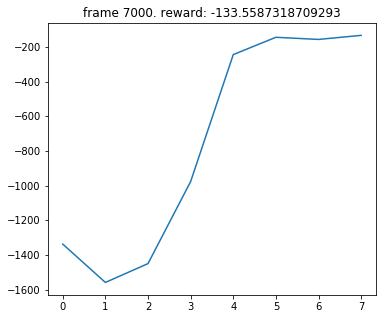

Process Process-10:
Process Process-14:
Process Process-2:
Process Process-16:
Process Process-12:
Process Process-11:
Process Process-6:
Process Process-3:
Process Process-4:
Process Process-1:
Process Process-9:
Process Process-7:
Process Process-8:
Process Process-15:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/richard/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/richard/anaconda3/lib/python3.6/mu

  File "<ipython-input-4-ceb390e42b3d>", line 9, in worker
    cmd, data = remote.recv()  # this remote is worker_remote
  File "/Users/richard/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
KeyboardInterrupt
  File "/Users/richard/anaconda3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/richard/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()
  File "<ipython-input-4-ceb390e42b3d>", line 9, in worker
    cmd, data = remote.recv()  # this remote is worker_remote
  File "/Users/richard/anaconda3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "<ipython-input-4-ceb390e42b3d>", line 9, in worker
    cmd, data = remote.recv()  # this remote is worker_remote
KeyboardInterrupt
  File "/Users/richard/anaconda3/lib/python3.6/multiprocessing/connection.py", line 250

KeyboardInterrupt: 

In [10]:
torch.manual_seed(args.seed)

if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)
    
def make_env():
    def _thunk():
        env = gym.make(args.env_name)
        return env

    return _thunk

env = gym.make(args.env_name) # made for testing
envs = [make_env() for i in range(args.num_processes)]
envs = SubprocVecEnv(envs)

actor_critic = Policy(envs.observation_space.shape, envs.action_space)

agent = A2C_ACKTR(actor_critic, acktr=True)

obs_shape = envs.observation_space.shape

rollouts = RolloutStorage(args.num_steps, args.num_processes, obs_shape, envs.action_space)

current_obs = torch.zeros(args.num_processes, *obs_shape)

obs = envs.reset()

current_obs = torch.tensor(obs).float()
rollouts.observations[0].copy_(current_obs)

test_rewards=[]

for j in range(args.num_frames):
    for step in range(args.num_steps):
        # Sample actions
        with torch.no_grad():

            value, action, action_log_prob = actor_critic.act(
                    rollouts.observations[step])

        cpu_action = action.cpu().numpy() # turn the action to numpy, which can be sent to interact with envs.
        obs, reward, done,_ = envs.step(cpu_action)
        
        reward = torch.tensor(reward).unsqueeze(1).float() 
        
        masks = torch.FloatTensor([[0.0] if done_ else [1.0] for done_ in done]) 
        
        current_obs *= masks 
        current_obs = torch.tensor(obs).float()
        rollouts.insert(current_obs,action, action_log_prob, value, reward, masks) # Insert the collected data to rollout
        
    with torch.no_grad():
        next_value = actor_critic.get_value(rollouts.observations[-1]).detach() # Get next_value

    rollouts.compute_returns(next_value, args.gamma, args.tau) # Compute the returns before the update, then in the update function, the advantage function can be accessible.
    allL, fisherL = agent.update(rollouts) # Optimizing the model
    rollouts.after_update() # Prepare for next iter
    
    
    if j % 1000 == 0:
        test_rewards.append(np.mean([test_env() for _ in range(10)]))
        plot(j, test_rewards)

            
            